In [15]:
import torch
import os
from torch import nn, optim
from tqdm import tqdm
import torch.nn as nn
from torchvision import models
from utils import *
from transformers import SwinForImageClassification

class HybridModel(nn.Module):
    def __init__(self, densenet_backbone, swin_model):
        super(HybridModel, self).__init__()
        self.densenet = densenet_backbone
        self.pool = nn.AdaptiveAvgPool2d((1, 1))  # Pooling to match Swin input shape
        self.swin = swin_model

    def forward(self, x):
        x = self.densenet(x)  # Extract features using DenseNet-121
        x = self.pool(x).flatten(1)  # Pool and flatten for Swin Transformer
        x = self.swin.classifier(x)  # Final classification
        return x

def load_model():
    # Load pretrained DenseNet-121
    densenet = models.densenet121(pretrained=True)

    # Remove the classifier head
    densenet_backbone = densenet.features

    # Load pretrained Swin Transformer
    swin_model = SwinForImageClassification.from_pretrained("microsoft/swin-tiny-patch4-window7-224")

    # Modify the input layer to accept DenseNet-121 features
    swin_model.classifier = nn.Linear(in_features=1024, out_features=5) 

    model = HybridModel(densenet_backbone, swin_model)

    return model


def train(model, train_loader, val_loader, preprocess_method):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=5e-5)

    num_epochs = 5
    val_accs = []
    val_losses = []
    train_accs = []
    train_losses = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 30)

        # Training
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in tqdm(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = correct / total
        train_accs.append(train_acc)
        train_losses.append(train_loss)
        print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}')

        acc, loss, precision, recall, f1 = evaluate(model, val_loader)
        val_accs.append(acc)
        val_losses.append(loss)

        print(f'Val Accuracy: {acc:.4f}')
        print(f'Val Loss: {loss:.4f}')
        print(f'Val Precision: {precision:.4f}')
        print(f'Val Recall: {recall:.4f}')
        print(f'Val F1 Score: {f1:.4f}')
        # Validation

        plot_accuracy_and_loss(train_accs, train_losses, val_accs, val_losses)


    if not os.path.exists('denseNet'):
        os.makedirs('denseNet')
        
    if preprocess_method == None:
        torch.save(model.state_dict(), f'denseNet/regular.pth')
    else:
        torch.save(model.state_dict(), f'denseNet/{preprocess_method.__name__}.pth')


def test(model, test_loader, preprocess_method):

    if preprocess_method == None:
         model.load_state_dict(torch.load(f'denseNet/regular.pth'))
    else:
        model.load_state_dict(torch.load(f'denseNet/{preprocess_method.__name__}.pth'))
    model.eval()

    acc, loss, precision, recall, f1 = evaluate(model, test_loader)

    print(f'Test Accuracy: {acc:.4f}')
    print(f'Test Loss: {loss:.4f}')
    print(f'Test  Precision: {precision:.4f}')
    print(f'Test  Recall: {recall:.4f}')
    print(f'Test  F1 Score: {f1:.4f}')


def main(preprocess_method=None):
    # Load training, validation, and test data
    full_train_balanced, full_val, full_test = load_data()

    # Get data loaders with no extra preprocessing
    train_loader, val_loader, test_loader, test_dataset = get_data_loaders(full_train_balanced, full_val, full_test, 16, preprocess_method)

    # Load efficientNet 
    model = load_model()

    # Train model
    train(model, train_loader, val_loader, preprocess_method)

    # Test model
    test(model, test_loader, preprocess_method)



c:\Users\rylee\anaconda3\envs\dr\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\rylee\anaconda3\envs\dr\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5
------------------------------


100%|██████████| 1563/1563 [2:39:07<00:00,  6.11s/it] 


Train Loss: 1.1180 | Train Acc: 0.5090


100%|██████████| 243/243 [17:09<00:00,  4.24s/it]


Val Accuracy: 0.5227
Val Loss: 0.9966
Val Precision: 0.7240
Val Recall: 0.5227
Val F1 Score: 0.5848


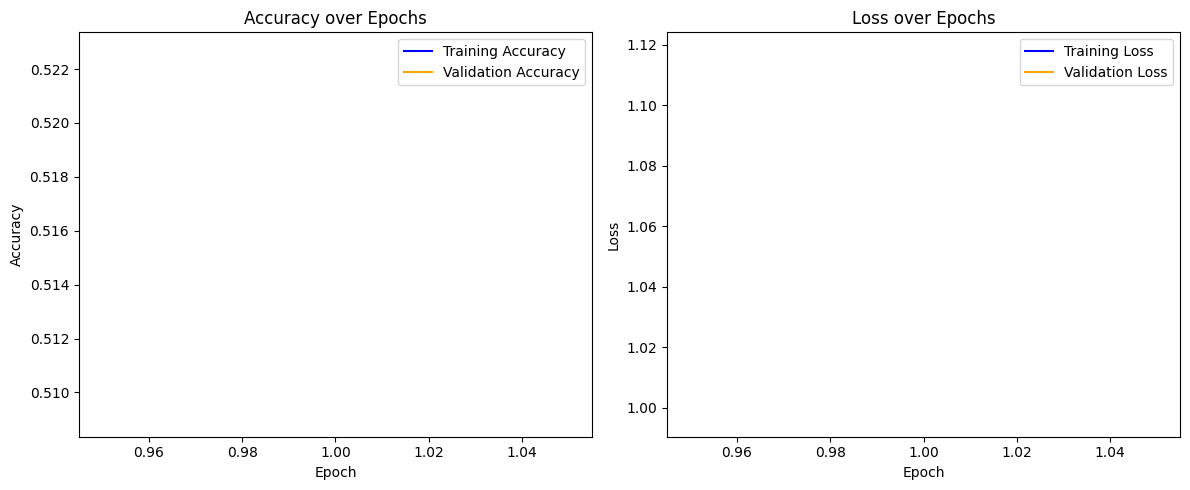

Epoch 2/5
------------------------------


100%|██████████| 1563/1563 [2:32:01<00:00,  5.84s/it]  


Train Loss: 0.8525 | Train Acc: 0.6309


100%|██████████| 243/243 [16:08<00:00,  3.99s/it]


Val Accuracy: 0.7433
Val Loss: 0.7524
Val Precision: 0.7444
Val Recall: 0.7433
Val F1 Score: 0.7384


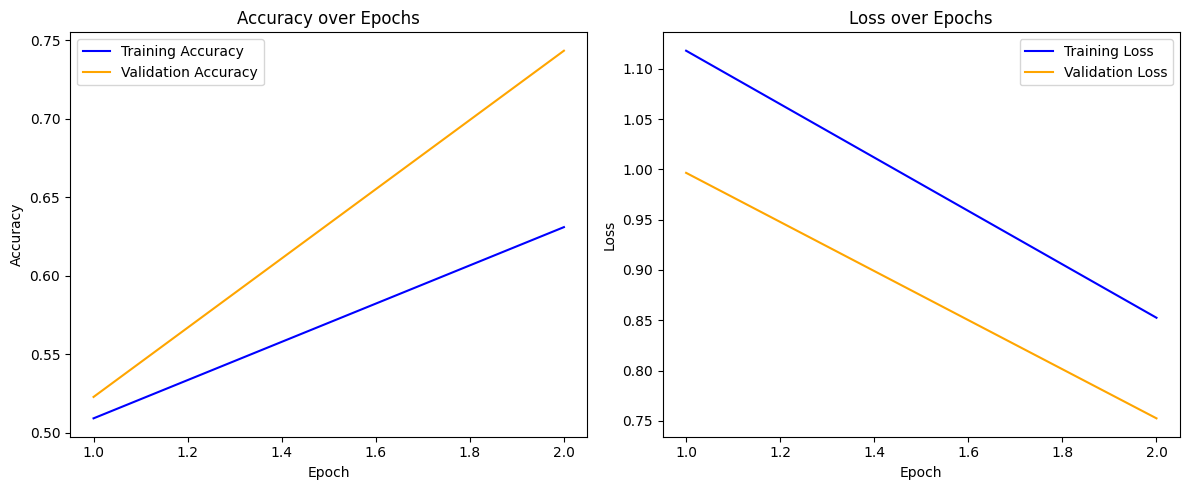

Epoch 3/5
------------------------------


100%|██████████| 1563/1563 [2:03:19<00:00,  4.73s/it] 


Train Loss: 0.7044 | Train Acc: 0.6980


100%|██████████| 243/243 [13:03<00:00,  3.22s/it]


Val Accuracy: 0.6972
Val Loss: 0.7780
Val Precision: 0.7381
Val Recall: 0.6972
Val F1 Score: 0.7144


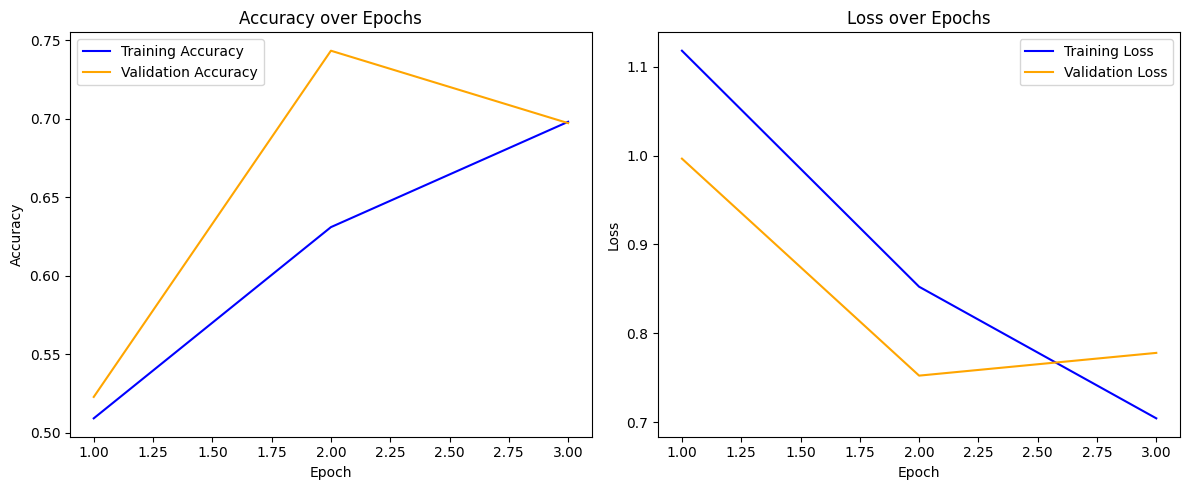

Epoch 4/5
------------------------------


100%|██████████| 1563/1563 [1:54:44<00:00,  4.40s/it]


Train Loss: 0.6014 | Train Acc: 0.7507


100%|██████████| 243/243 [12:30<00:00,  3.09s/it]


Val Accuracy: 0.6943
Val Loss: 0.8052
Val Precision: 0.7496
Val Recall: 0.6943
Val F1 Score: 0.7169


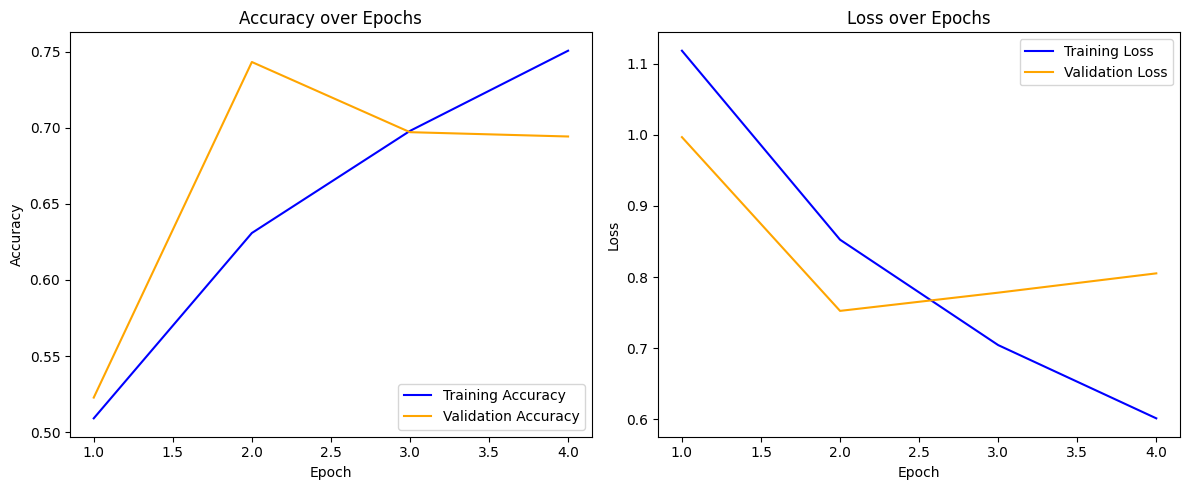

Epoch 5/5
------------------------------


 56%|█████▌    | 878/1563 [1:03:05<47:12,  4.14s/it]

In [16]:
main(clahe_green_channel)

In [12]:
from utils import *

def backup_test(preprocess_method=None):
    # Load training, validation, and test data
    full_train_balanced, full_val, full_test = load_data()

    # Get data loaders with no extra preprocessing
    train_loader, val_loader, test_loader, test_dataset = get_data_loaders(full_train_balanced, full_val, full_test, 16, preprocess_method)

    model = load_model()
    if preprocess_method == None:
         model.load_state_dict(torch.load(f'denseNet/regular.pth'))
    else:
        model.load_state_dict(torch.load(f'denseNet/{preprocess_method.__name__}.pth'))
    model.eval()

    acc, loss, precision, recall, f1 = evaluate(model, test_loader)

    print(f'Test Accuracy: {acc:.4f}')
    print(f'Test Loss: {loss:.4f}')
    print(f'Test  Precision: {precision:.4f}')
    print(f'Test  Recall: {recall:.4f}')
    print(f'Test  F1 Score: {f1:.4f}')

backup_test()
